In [1]:
import sys

import numpy as np
import pandas as pd

import progressbar

from sklearn.metrics import confusion_matrix, auc, accuracy_score
from sklearn.preprocessing import normalize, Normalizer, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
old = pd.read_csv('data/spambase_old.csv')
new = pd.read_csv('data/spambase_new.csv')

In [4]:
X_train = old.drop(['label'], axis=1).as_matrix()
y_train = old['label'].as_matrix()

In [5]:
X_test = new.drop(['label'], axis=1).as_matrix()
y_test = new['label'].as_matrix()

In [6]:
def sigmoid(x):
    return 1./(1. + np.exp(-1.*x))

class CustomLogisticRegression(object):
    def __init__(self, learning_rate, l2, max_iters, batch_size, threshold=0.5):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.threshold = threshold
        self.l2 = l2
        self.batch_size = batch_size
    
    def fit(self, X, y, plot=False):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        y = np.array(y)
        
        batch_size = int(self.batch_size*X.shape[0])
        
        self.weights = np.random.randn(X.shape[1])*self.learning_rate
#         self.weights = np.zeros(X.shape[1])
        
        cost_list = list()
        for it in range(self.max_iters):
            idx = np.random.choice(X.shape[0], size=batch_size, replace=False)
            for val, y_true in zip(X[idx], y[idx]):           
                self.weights += self.learning_rate*(y_true - sigmoid(np.dot(self.weights, val)))*val/len(idx)
            
            if plot:
                cost = self._cost(X, y)
                cost_list.append(cost)
        
        if plot:
            plt.plot(range(self.max_iters), cost_list)               
                
            
    def _cost(self, X, y):
        return np.mean([np.log(1 + np.exp(-1.*y_true, np.dot(self.weights, val))) for val, y_true in zip(X, y)])
        
    def predict_prob(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), np.array(X)])
        return sigmoid(np.dot(X, self.weights.T))
    
    def predict(self, X):
        probs = self.predict_prob(X)
        
        return np.array(probs >= self.threshold).astype(int)
    
    def _predict_one(self, val):
        return sigmoid(self.weights, val)        

In [11]:
def get_fpr_tpr(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[1][0]
    FN = cm[0][1]

    return 1.*FP/(FP + TN), 1.*TP/(TP+FN)

def plot_roc_lr(X_train, y_train, X_test, y_test, norm):
    score = list()
    
    if norm:
        transformer = StandardScaler()
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.transform(X_test)
    
    pbar = progressbar.ProgressBar()
    pbar.start()
    for t in pbar(np.arange(0, 1.01, 0.025)):
        lr = CustomLogisticRegression(learning_rate=0.0005, l2=1., batch_size=0.05, threshold=t, max_iters=10000)
        lr.fit(X_train, y_train)
        preds = lr.predict(X_test)
        
        fpr, tpr = get_fpr_tpr(y_test, preds)
        score.append((fpr, tpr))
        pbar.update()
        
    score = sorted(score, key = lambda x: x[0])
    fpr = [s[0] for s in score]
    tpr = [s[1] for s in score]
    auc_score = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(fpr, tpr)   
    plt.plot([0, 1], [0, 1], ls= '--')
    plt.title('auc score: {}'.format(auc_score))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    
    return auc_score

100% |########################################################################|


0.91066514663102449

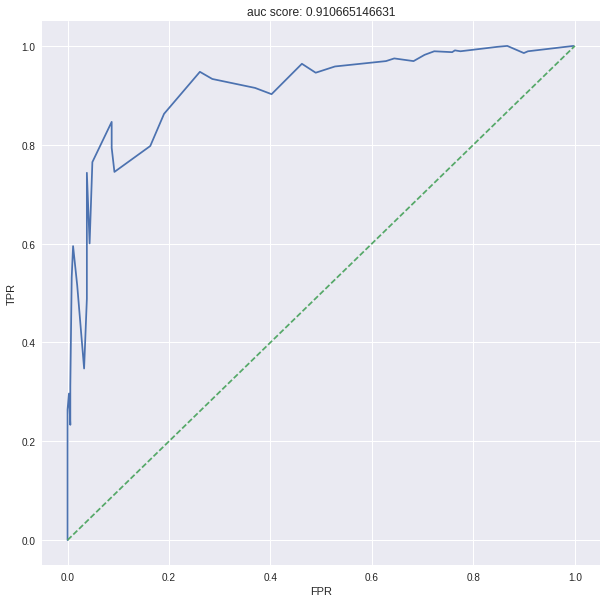

In [12]:
plot_roc_lr(X_train, y_train, X_test, y_test, norm=False)

100% |########################################################################|


0.9569762756506015

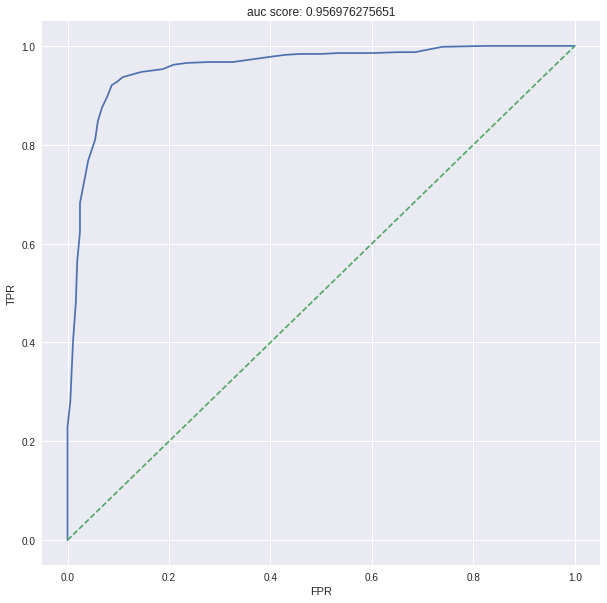

In [13]:
plot_roc_lr(X_train, y_train, X_test, y_test, norm=True)